In [90]:
import pandas as pd
import numpy as np
import requests 
import config # gitignored config.py file with API keys
import json 

from geopy.geocoders import Nominatim
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
from sklearn.cluster import KMeans 

import folium 
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

#import matplotlib.cm as cm
#import matplotlib.colors as colors


matplotlib.style.use('ggplot')
sns.set(rc={'figure.figsize':(20,8.27)})
%matplotlib inline

# Define the urban area: ZIP, Price, Rent, Lat, and Lng 
### Pulling all zip codes for the urban area

In [3]:
# Source https://worldpostalcode.com/united-states/new-york/new-york-city 
# retrieved on 05/28/2020
df_zipcodes = pd.read_csv('nyc_boroughs.csv', index_col = 0)
df_zipcodes.tail(2)

,zip,borough
238,11694,Queens
239,11697,Queens


In [4]:
df_zipcodes.shape

(240, 2)

This looks like a good size (n=240) sample of zip codes that can be used for the analysis

In [5]:
df_zipcodes.rename(columns={'borough':'Borough', 'zip':'Zipcode'}, inplace=True)
df_zipcodes.groupby('Borough').count()

,Zipcode
Borough,
Bronx,25
Brooklyn,43
Manhattan,96
Queens,63
Staten,13


### Adding Zillow price estimates 
Use the list of sample zip codes to get good price estimates, in my case, latest estimates of 2-bedroom condo units

In [6]:
# Source: https://www.zillow.com/research/data/
# retrieved on 05-18-2020
df_prices = pd.read_csv('condo_prices.csv', index_col=0)

In [7]:
# This data set contains zillow estimates for the entire nation
df_prices.shape

(10939, 299)

In [8]:
# Inspect the columns 
df_prices.head(2)

,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,1996-01-31,1996-02-29,...,2019-06-30,2019-07-31,2019-08-31,2019-09-30,2019-10-31,2019-11-30,2019-12-31,2020-01-31,2020-02-29,2020-03-31
RegionID,,,,,,,,,,,,,,,,,,,,,
61639,0,10025,Zip,NY,NY,New York,New York-Newark-Jersey City,New York County,215591.0,214255.0,...,1249908.0,1239499.0,1219219.0,1203053.0,1188642.0,1182534.0,1175894.0,1153407.0,1123011.0,1085220.0
84654,1,60657,Zip,IL,IL,Chicago,Chicago-Naperville-Elgin,Cook County,194597.0,194456.0,...,403689.0,403756.0,403181.0,402122.0,401073.0,400025.0,399451.0,399424.0,400541.0,402007.0


In [9]:
# Only need relevant price, say 2019-11-30, and RegionName (zipcode), plus Metro for checks
df_prices.drop(df_prices.columns.difference(['RegionName', '2019-11-30']), 1, inplace=True)

In [10]:
df_nyc_prices = df_zipcodes.merge(df_prices, left_on='Zipcode', right_on='RegionName')
df_nyc_prices.shape

(157, 4)

Merged data set has less rows than original zip codes list but thats fine as there might have been some P.O boxes or reserved codes. The new list now has meaningful first feature - price estimate.

Check if all observations map to New York city boroughs or if there any unexpected values. Looks fine so far!

In [11]:
df_nyc_prices.groupby('Borough').count()

,Zipcode,RegionName,2019-11-30
Borough,,,
Bronx,16,16,16
Brooklyn,38,38,38
Manhattan,41,41,41
Queens,51,51,51
Staten,11,11,11


Finally, drop control column 'RegionName', rename the column to 'Price' and check if there are any missing values.

In [12]:
df_nyc_prices.rename(columns={'2019-11-30':'Price'}, inplace=True)
df_nyc_prices.drop(['RegionName'], axis=1, inplace=True)

In [13]:
df_nyc_prices['Price'].isna().values.any()

False

In [14]:
df_nyc_prices.head()

,Zipcode,Borough,Price
0,10001,Manhattan,1274766.0
1,10002,Manhattan,1103197.0
2,10003,Manhattan,1065001.0
3,10004,Manhattan,1236730.0
4,10005,Manhattan,1163758.0


### Addining Zillow rental estimates

In [15]:
df_rents=pd.read_csv('condo_rentals.csv', index_col = 0)

In [16]:
df_rents.shape

(13181, 119)

In [17]:
df_rents.head(2)

,RegionName,City,State,Metro,CountyName,SizeRank,2010-09,2010-10,2010-11,2010-12,...,2019-04,2019-05,2019-06,2019-07,2019-08,2019-09,2019-10,2019-11,2019-12,2020-01
RegionID,,,,,,,,,,,,,,,,,,,,,
61639,10025,New York,NY,New York-Newark-Jersey City,New York County,1,3031.0,3058.0,3031.0,3015.0,...,3785.0,3788.0,3786.0,3784.0,3766.0,3779.0,3843.0,3873.0,3835.0,NaN
84654,60657,Chicago,IL,Chicago-Naperville-Elgin,Cook County,2,1790.0,1787.0,1784.0,1774.0,...,2039.0,2070.0,2105.0,2140.0,2168.0,2185.0,2125.0,NaN,2053.0,1996.0


In [18]:
# Only need relevant price, say 2019-11-30, and RegionName (zipcode), plus Metro for checks
df_rents.drop(df_rents.columns.difference(['RegionName', '2019-11']), 1, inplace=True)

In [19]:
df_rents.head(2)

,RegionName,2019-11
RegionID,,
61639,10025,3873.0
84654,60657,NaN


In [20]:
df_nyc_prices_rents = df_nyc_prices.merge(df_rents, left_on='Zipcode', right_on='RegionName')
df_nyc_prices_rents.shape

(136, 5)

More observations (rows) were lost because not all zip codes had a rental estimate. Still seems to be a reasonable sample size (n=136).

In [21]:
df_nyc_prices_rents.groupby('Borough').count()

,Zipcode,Price,RegionName,2019-11
Borough,,,,
Bronx,16,16,16,15
Brooklyn,34,34,34,29
Manhattan,26,26,26,25
Queens,49,49,49,49
Staten,11,11,11,11


Moreover, from the grouped table above, it seems that some zip codes do have a price estimate but do not have rent estimate. So, drop missing values and check the data set.

Drop control column and rename column 'Rent'

In [22]:
df_nyc_prices_rents.rename(columns={'2019-11':'Rent'}, inplace=True)
df_nyc_prices_rents.drop(['RegionName'], axis=1, inplace=True)

In [23]:
df_nyc_prices_rents['Rent'].isna().values.any()

True

In [24]:
df_nyc_prices_rents.shape

(136, 4)

In [25]:
df_nyc_prices_rents.dropna(inplace=True)

In [26]:
df_nyc_prices_rents.shape

(129, 4)

In [27]:
df_nyc_prices_rents['Rent'].isna().values.any()

False

In [28]:
df_nyc_prices_rents.head(2)

,Zipcode,Borough,Price,Rent
0,10001,Manhattan,1274766.0,3667.0
1,10002,Manhattan,1103197.0,3759.0


Final size is smaller (n=129) but there are no missing values

## Visual exploratory analysis 

Inspect the rents visually with box plots

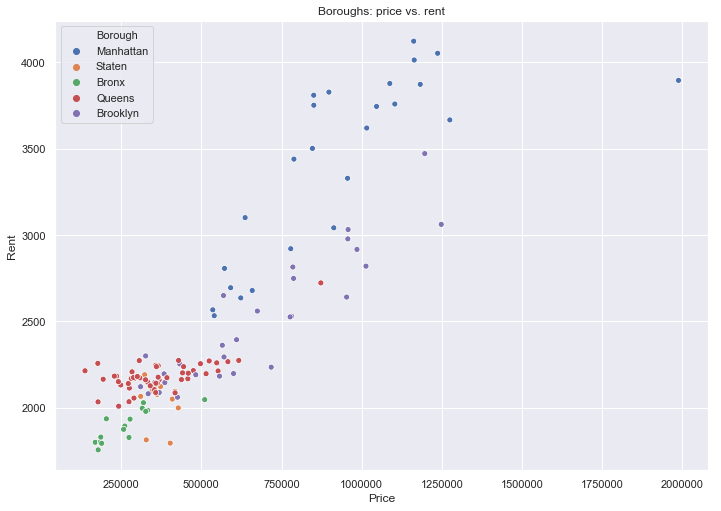

In [30]:
sns.scatterplot(x='Price', y='Rent', data=df_nyc_prices_rents, hue = 'Borough')
plt.gcf().set_size_inches(11.7, 8.27)
plt.title("Boroughs: price vs. rent")
plt.show()

When plotting 'Rent' against 'Price" it seems that the data is not homegeneous at all. 

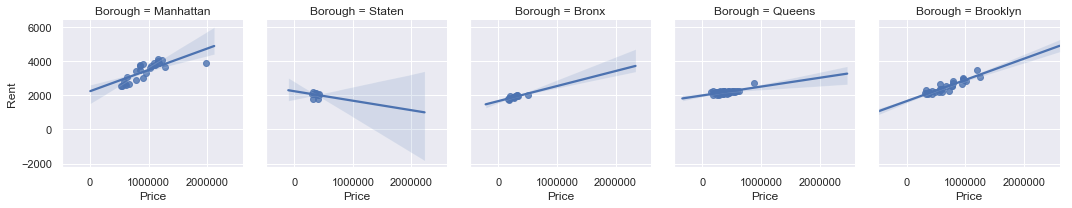

In [31]:
g1 = sns.lmplot(x='Price', y='Rent', data=df_nyc_prices_rents, ci=85,
                col='Borough', height=3, robust=False)
g1 = g1.set_axis_labels('Price', 'Rent')
plt.show()

Splitting by boroughs confirms this idea. When looking at the slope of regression lines, rent/price relationship appears to be different. There are at list 3 distinct groups: 1) Manhattan, 2) Staten,  and 3) Bronx, Queens and Brooklyn.

### Algorithmic *k*-means clustering 

In [33]:
k_means = KMeans(init="k-means++", n_clusters=3, n_init=12)
#X = df_nyc_prices_rents[['Price', 'Rent']]
k_means.fit(df_nyc_prices_rents[['Price', 'Rent']])

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=12, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [34]:
k_means_cluster_centers = k_means.cluster_centers_
pd.DataFrame(k_means_cluster_centers, columns=['Price', 'Rent'])

,Price,Rent
0,1.116881e+06,3487.450000
1,3.237901e+05,2094.460526
2,6.511839e+05,2619.575758


In [35]:
labels = k_means.labels_

In [36]:
df_nyc_prices_rents["Cluster"] = labels
df_nyc_prices_rents.head(5)

,Zipcode,Borough,Price,Rent,Cluster
0,10001,Manhattan,1274766.0,3667.0,0
1,10002,Manhattan,1103197.0,3759.0,0
2,10004,Manhattan,1236730.0,4053.0,0
3,10005,Manhattan,1163758.0,4014.0,0
4,10006,Manhattan,850713.0,3752.0,2


In [37]:
df_nyc_prices_rents.groupby('Cluster').count()

,Zipcode,Borough,Price,Rent
Cluster,,,,
0,20,20,20,20
1,76,76,76,76
2,33,33,33,33


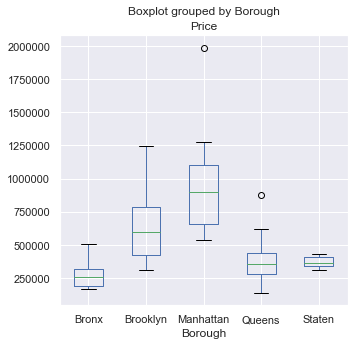

In [38]:
df_nyc_prices_rents.boxplot(column='Price', by='Borough', figsize=(5, 5), rot=0)
plt.show()

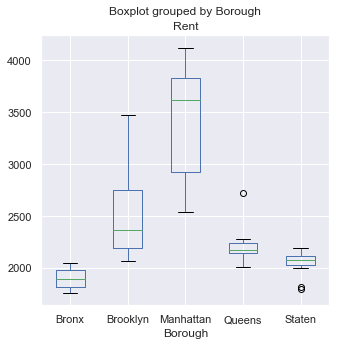

In [39]:
df_nyc_prices_rents.boxplot(column='Rent', by='Borough', figsize=(5, 5), rot=0)
plt.show()

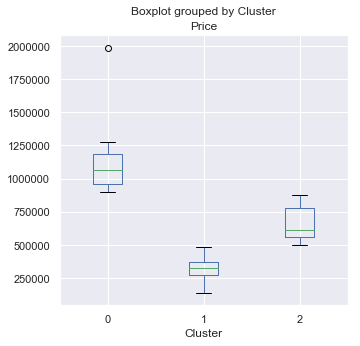

In [42]:
df_nyc_prices_rents.boxplot(column='Price', by='Cluster', figsize=(5, 5), rot=0)
plt.show()

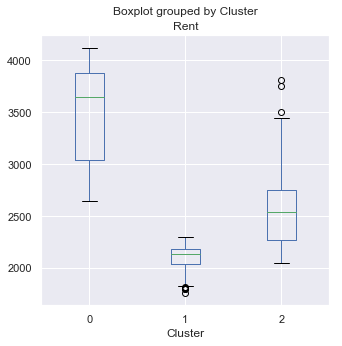

In [43]:
df_nyc_prices_rents.boxplot(column='Rent', by='Cluster', figsize=(5, 5), rot=0)
plt.show()

## Adding geospatial data

In [44]:
# Source: https://gist.github.com/erichurst/7882666#file-us-zip-codes-from-2013-government-data
# Retrieved on 05/28/200
#df_zip_coordinates = pd.read_csv('https://gist.githubusercontent.com/erichurst/7882666/raw/5bdc46db47d9515269ab12ed6fb2850377fd869e/US%2520Zip%2520Codes%2520from%25202013%2520Government%2520Data')
# Due to importance of these coordinates, I make a local csv copy
#df_zip_coordinates.to_csv('zip_coordinates.csv')

In [45]:
df_zip_coordinates= pd.read_csv('zip_coordinates.csv', index_col = 0)
df_zip_coordinates.head()

,ZIP,LAT,LNG
0,601,18.180555,-66.749961
1,602,18.361945,-67.175597
2,603,18.455183,-67.119887
3,606,18.158345,-66.932911
4,610,18.295366,-67.125135


In [46]:
df_nyc_prices_rents = df_nyc_prices_rents.merge(df_zip_coordinates, left_on='Zipcode', right_on='ZIP')

In [47]:
df_nyc_prices_rents.head()

,Zipcode,Borough,Price,Rent,Cluster,ZIP,LAT,LNG
0,10001,Manhattan,1274766.0,3667.0,0,10001,40.750633,-73.997177
1,10002,Manhattan,1103197.0,3759.0,0,10002,40.715775,-73.986212
2,10004,Manhattan,1236730.0,4053.0,0,10004,40.688630,-74.018244
3,10005,Manhattan,1163758.0,4014.0,0,10005,40.706027,-74.008835
4,10006,Manhattan,850713.0,3752.0,2,10006,40.709614,-74.012954


In [48]:
df_nyc_prices_rents.drop(['ZIP'], axis=1, inplace=True)
df_nyc_prices_rents.shape

(128, 7)

In [49]:
df_nyc_prices_rents['LAT'].isna().values.any()

False

In [50]:
df_nyc_prices_rents['LNG'].isna().values.any()

False

In [51]:
df_nyc_prices_rents.head(2)

,Zipcode,Borough,Price,Rent,Cluster,LAT,LNG
0,10001,Manhattan,1274766.0,3667.0,0,40.750633,-73.997177
1,10002,Manhattan,1103197.0,3759.0,0,40.715775,-73.986212


In [414]:
# Creat a local copy of teh entire data set for audit purposes:
#df_nyc_prices_rents.to_csv('nyc_pyces_rents.csv')

# Adding Local Venues

### Connecting to Foursquares server and data pull

In [72]:
#config.py file stores Client_ID and Client_Secret and is in gitignore
CLIENT_ID = config.CLIENT_ID 
CLIENT_SECRET = config.CLIENT_SECRET 
VERSION = '20191130'

In [73]:
latitude = df_nyc_prices_rents.loc[0, 'LAT'] 
longitude = df_nyc_prices_rents.loc[0, 'LNG'] # neighborhood longitude value
cluster = df_nyc_prices_rents.loc[0, 'Cluster'] # neighborhood name

#print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
#                                                               neighborhood_latitude, 
#                                                               neighborhood_longitude))

LIMIT = 500 
radius = 500 

In [74]:
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude, 
    longitude, 
    radius, 
    LIMIT)


In [75]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5ed429901a4b0a001bd3a6ff'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'},
    {'name': '$-$$$$', 'key': 'price'}]},
  'headerLocation': 'Chelsea',
  'headerFullLocation': 'Chelsea, New York',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 61,
  'suggestedBounds': {'ne': {'lat': 40.7551330045, 'lng': -73.99124794397473},
   'sw': {'lat': 40.7461329955, 'lng': -74.00310605602532}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '59ca57dd3d47910ad148e668',
       'name': 'Bluestone Lane',
       'location': {'address': '435 W 31st St',
        'crossStreet': 'btwn 9th & Dyer Ave',
        'lat': 40.7520681,
        'lng': -73.9988477,
        'labeled

In [91]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [92]:
venues = results['response']['groups'][0]['items']
    
df_nearby_venues = json_normalize(venues) 
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
df_nearby_venues = df_nearby_venues.loc[:, filtered_columns]
df_nearby_venues['venue.categories'] = df_nearby_venues.apply(get_category_type, axis=1)
df_nearby_venues.columns = [col.split(".")[-1] for col in df_nearby_venues.columns]

df_nearby_venues.head(2)

,name,categories,lat,lng
0,Bluestone Lane,Coffee Shop,40.752068,-73.998848
1,You Should Be Dancing…..! / Club 412,Dance Studio,40.750306,-73.994743


In [81]:
print('{} venues were returned by Foursquare.'.format(df_nearby_venues.shape[1]))

4 venues were returned by Foursquare.


In [96]:
def getNearbyVenues(zipcodes, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for zipcode, lat, lng in zip(zipcodes, latitudes, longitudes):
        print('Retrieving local values for the zip code:', zipcode)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            zipcode, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Zip', 
                  'Latitude', 
                  'Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [ ]:
nyc_venues = getNearbyVenues(zipcodes=df_nyc_prices_rents['Zipcode'],
                             latitudes=df_nyc_prices_rents['LAT'],
                             longitudes=df_nyc_prices_rents['LNG']
                            )


Retrieving local values for the zip code: 10001
Retrieving local values for the zip code: 10002
Retrieving local values for the zip code: 10004
Retrieving local values for the zip code: 10005
Retrieving local values for the zip code: 10006
Retrieving local values for the zip code: 10009
Retrieving local values for the zip code: 10010
Retrieving local values for the zip code: 10016
Retrieving local values for the zip code: 10017
Retrieving local values for the zip code: 10018
Retrieving local values for the zip code: 10019
Retrieving local values for the zip code: 10022
Retrieving local values for the zip code: 10023
Retrieving local values for the zip code: 10025
Retrieving local values for the zip code: 10026
Retrieving local values for the zip code: 10030
Retrieving local values for the zip code: 10031
Retrieving local values for the zip code: 10032
Retrieving local values for the zip code: 10033
Retrieving local values for the zip code: 10034
Retrieving local values for the zip code

In [95]:
print(nyc_venues.shape)
nyc_venues.to_csv('nyc_venues_r500.csv')
nyc_venues.tail()

(5142, 7)


,Zip,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
5137,11691,40.601278,-73.761651,A Train Shuttle Bus Stop,40.599722,-73.761665,Bus Stop
5138,11697,40.555688,-73.920663,Pelham Walk,40.558499,-73.922276,Trail
5139,11697,40.555688,-73.920663,"Ocean Ave, Breezy Pt",40.558337,-73.918602,Beach
5140,11697,40.555688,-73.920663,Dugout,40.559381,-73.919297,Pizza Place
5141,11697,40.555688,-73.920663,Breezy Point Ballfield Playground,40.559614,-73.919073,Park


In [467]:
nyc_venues.groupby(['Zip', 'Venue Category']).count()

Latitude  Longitude  Venue  \
Zip   Venue Category                                                
10001 Bagel Shop                              1          1      1   
      Bakery                                  2          2      2   
      Basketball Stadium                      1          1      1   
      Boxing Gym                              1          1      1   
      Breakfast Spot                          1          1      1   
      Burger Joint                            3          3      3   
      Café                                    2          2      2   
      Camera Store                            1          1      1   
      Chinese Restaurant                      2          2      2   
      Church                                  1          1      1   
      Coffee Shop                             3          3      3   
      Cupcake Shop                            1          1      1   
      Dance Studio                            5          5      5   
      Deli / Bodega                           1          1      1   
      Dive Bar                                1          1      1   
      Donut Shop                              1          1      1   
      Fast Food Restaurant                    1          1      1   
      Food Court                              1          1      1   
      French Restaurant                       1          1      1   
      Furniture / Home Store                  2          2      2   
      Grocery Store                           1          1      1   
      Gym                                     1          1      1   
      Gym / Fitness Center                    2          2      2   
      Health & Beauty Service                 1          1      1   
      Hotel                                   3          3      3   
      Indie Theater                           2          2      2   
      Italian Restaurant                      1          1      1   
      Jewelry Store                           1          1      1   
      Lounge                                  1          1      1   
      Martial Arts Dojo                       1          1      1   
...                                         ...        ...    ...   
11435 Nightclub                               1          1      1   
      Pharmacy                                1          1      1   
      Pizza Place                             5          5      5   
      Platform                                2          2      2   
      Rental Car Location                     1          1      1   
      Salvadoran Restaurant                   1          1      1   
      Sandwich Place                          3          3      3   
      Seafood Restaurant                      1          1      1   
      Sports Bar                              1          1      1   
      Supermarket                             1          1      1   
      Train                                   1          1      1   
      Train Station                           1          1      1   
      Women's Store                           1          1      1   
11436 Caribbean Restaurant                    1          1      1   
      Convenience Store                       1          1      1   
      Deli / Bodega                           1          1      1   
      Donut Shop                              1          1      1   
      Fried Chicken Joint                     1          1      1   
      Grocery Store                           2          2      2   
      Pharmacy                                1          1      1   
      Southern / Soul Food Restaurant         2          2      2   
11691 Beach                                   1          1      1   
      Bus Stop                                1          1      1   
      Chinese Restaurant                      1          1      1   
      Deli / Bodega                           1          1      1   
      Food & Drink Shop              

In [455]:
print('There are {} uniques categories.'.format(len(nyc_venues['Venue Category'].unique())))

There are 371 uniques categories.


In [194]:
# TODO: focus on tahe most popular venues by zip code; and need at least 20 of same type

In [468]:
#nyc_venues.head()


# one hot encoding
nyc_onehot = pd.get_dummies(nyc_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
nyc_onehot['Zip'] = nyc_venues['Zip'] 

# move neighborhood column to the first column
fixed_columns = [nyc_onehot.columns[-1]] + list(nyc_onehot.columns[:-1])
nyc_onehot = nyc_onehot[fixed_columns]

nyc_onehot.head()

,Zip,Accessories Store,Acupuncturist,Adult Boutique,Afghan Restaurant,African Restaurant,Airport Lounge,Airport Tram,American Restaurant,Antique Shop,...,Video Store,Vietnamese Restaurant,Warehouse Store,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,10001,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,10001,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,10001,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,10001,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,10001,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [469]:
nyc_onehot.shape

(5139, 372)

In [471]:
nyc_grouped = nyc_onehot.groupby('Zip').mean().reset_index()
nyc_grouped.head()

,Zip,Accessories Store,Acupuncturist,Adult Boutique,Afghan Restaurant,African Restaurant,Airport Lounge,Airport Tram,American Restaurant,Antique Shop,...,Video Store,Vietnamese Restaurant,Warehouse Store,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,10001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,...,0.0,0.00,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.00
1,10002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.03,0.0,...,0.0,0.02,0.0,0.0,0.0,0.01,0.00,0.0,0.01,0.00
2,10004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,...,0.0,0.00,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.00
3,10005,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.07,0.0,...,0.0,0.00,0.0,0.0,0.0,0.00,0.01,0.0,0.00,0.01
4,10006,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.02,0.0,...,0.0,0.00,0.0,0.0,0.0,0.00,0.03,0.0,0.01,0.00


In [472]:
nyc_grouped.shape

(128, 372)

In [507]:
df_nyc_prices_rents.head()

,Zipcode,Borough,Price,Rent,Cluster,LAT,LNG
0,10001,Manhattan,1274766.0,3667.0,2,40.750633,-73.997177
1,10002,Manhattan,1103197.0,3759.0,2,40.715775,-73.986212
2,10004,Manhattan,1236730.0,4053.0,2,40.688630,-74.018244
3,10005,Manhattan,1163758.0,4014.0,2,40.706027,-74.008835
4,10006,Manhattan,850713.0,3752.0,1,40.709614,-74.012954


In [662]:
df_final_dataset = df_nyc_prices_rents.merge(nyc_grouped, left_on='Zipcode', right_on='Zip')
df_final_dataset.head(2)

,Zipcode,Borough,Price,Rent,Cluster,LAT,LNG,Zip,Accessories Store,Acupuncturist,...,Video Store,Vietnamese Restaurant,Warehouse Store,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,10001,Manhattan,1274766.0,3667.0,2,40.750633,-73.997177,10001,0.0,0.0,...,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0
1,10002,Manhattan,1103197.0,3759.0,2,40.715775,-73.986212,10002,0.0,0.0,...,0.0,0.02,0.0,0.0,0.0,0.01,0.0,0.0,0.01,0.0


In [663]:
y_price = df_final_dataset['Price']
y_rent = df_final_dataset['Rent']
#y_price

In [664]:
df_final_dataset.head(2)

,Zipcode,Borough,Price,Rent,Cluster,LAT,LNG,Zip,Accessories Store,Acupuncturist,...,Video Store,Vietnamese Restaurant,Warehouse Store,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,10001,Manhattan,1274766.0,3667.0,2,40.750633,-73.997177,10001,0.0,0.0,...,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0
1,10002,Manhattan,1103197.0,3759.0,2,40.715775,-73.986212,10002,0.0,0.0,...,0.0,0.02,0.0,0.0,0.0,0.01,0.0,0.0,0.01,0.0


In [549]:
X = df_final_dataset.drop(['Zipcode', 'Borough', 'Price', 'Rent', 'Cluster',
                                  'LAT', 'LNG', 'Zip'], axis=1)

#df_nyc_prices_rents.drop(['RegionName'], axis=1, inplace=True)
# Saving feature names for later use
feature_list = list(X.columns)

In [665]:
# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split
# Split the data into training and testing sets
X_train, X_test, y_price_train, y_price_test = train_test_split(
    X, y_price, test_size = 0.20, random_state = 0)

X_train, X_test, y_rent_train, y_rent_test = train_test_split(
    X, y_rent, test_size = 0.20, random_state = 0)

In [573]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
#X, y = make_regression(n_features=4, n_informative=2, random_state=0, shuffle=False)
regr = RandomForestRegressor(max_depth=5, n_estimators=1000, random_state=0)
regr.fit(X_train, y_price_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=1000,
                      n_jobs=None, oob_score=False, random_state=0, verbose=0,
                      warm_start=False)

In [574]:
print("Training score: ", regr.score(X_train, y_price_train))

Training score:  0.8843074634648042


In [575]:
# Use the forest's predict method on the test data
predictions = regr.predict(X_test)
# Calculate the absolute errors
errors = abs(predictions - y_price_test)
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / y_price_test)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Accuracy: 75.94 %.


In [568]:
#!pip install pydot

In [577]:
# Import tools needed for visualization
from sklearn.tree import export_graphviz
import pydot
# Pull out one tree from the forest
tree = regr.estimators_[5]

# Export the image to a dot file
export_graphviz(tree, out_file = 'tree_price.dot', feature_names = feature_list, rounded = True, precision = 1)
# Use dot file to create a graph
(graph, ) = pydot.graph_from_dot_file('tree_price.dot')
# Write graph to a png file
graph.write_png('tree_price.png')

In [599]:
# Get numerical feature importances
importances = list(regr.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) 
                       for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

In [651]:
feature_importances[0:20]

[('Gym / Fitness Center', 0.17),
 ('Wine Shop', 0.13),
 ('Coffee Shop', 0.1),
 ('French Restaurant', 0.09),
 ('Concert Hall', 0.05),
 ('Cocktail Bar', 0.04),
 ('American Restaurant', 0.02),
 ('Café', 0.02),
 ('Cycle Studio', 0.02),
 ('Sandwich Place', 0.02),
 ('Bakery', 0.01),
 ('Beer Bar', 0.01),
 ('Caribbean Restaurant', 0.01),
 ('Chinese Restaurant', 0.01),
 ('Climbing Gym', 0.01),
 ('Donut Shop', 0.01),
 ('Grocery Store', 0.01),
 ('Gym', 0.01),
 ('Gymnastics Gym', 0.01),
 ('High School', 0.01)]

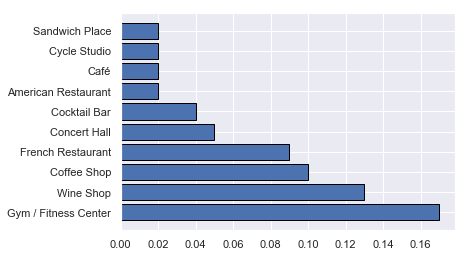

In [647]:
x_val = [x[0] for x in feature_importances[0:10]]
y_val = [x[1] for x in feature_importances[0:10]]
plt.barh(x_val,y_val, edgecolor='black')
plt.show()

In [672]:
fi = pd.DataFrame({'Predicting_price': list(X_train.columns),
                   'Importance_price': regr.feature_importances_}).\
                    sort_values('Importance_price', ascending = False)

In [673]:
fi

,Predicting_price,Importance_price
162,Gym / Fitness Center,0.170610
367,Wine Shop,0.125780
81,Coffee Shop,0.096843
143,French Restaurant,0.090544
90,Concert Hall,0.050361
80,Cocktail Bar,0.037382
62,Café,0.020058
100,Cycle Studio,0.018704
7,American Restaurant,0.015956
293,Sandwich Place,0.015318


In [666]:
from sklearn.linear_model import Lasso

In [667]:
lasso = Lasso()
lasso.fit(X_train, y_price_train)

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5465396384.354862, tolerance: 1010340542.7663845
  positive)


Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [652]:
print("Training score: ", lasso.score(X_train, y_price_train))

Training score:  0.9999676692795266


In [653]:
# Use the forest's predict method on the test data
predictions = lasso.predict(X_test)
# Calculate the absolute errors
errors = abs(predictions - y_price_test)
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / y_price_test)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Accuracy: 10.46 %.


In [659]:
train_score=lasso.score(X_train,y_price_train)
test_score=lasso.score(X_test,y_price_test)
coeff_used = np.sum(lasso.coef_!=0)
print ("training score:", train_score)
print ("test score: ", test_score)
print ("number of features used: ", coeff_used)

training score: 0.9999676692795266
test score:  -3.5600261843433696
number of features used:  115


In [660]:
X_train.shape

(102, 371)